# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.297527,False,-2.444230
1,-0.750903,True,4.586710
2,0.423814,True,4.597054
3,-0.492698,True,3.996149
4,-1.196889,False,-0.901873
...,...,...,...
995,-1.008442,True,4.409140
996,-0.418388,False,1.331345
997,-0.773559,True,4.927800
998,-0.630556,False,-1.122099


<Axes: xlabel='v0'>

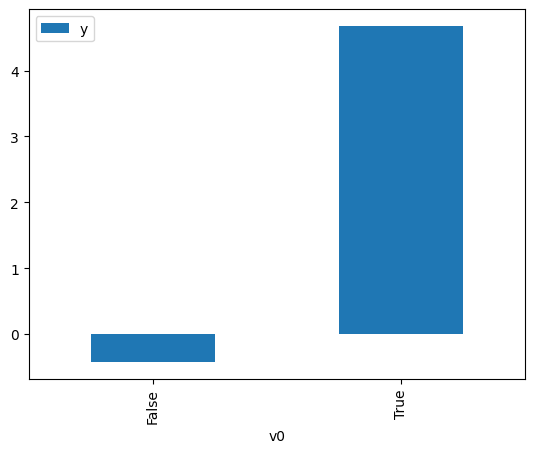

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

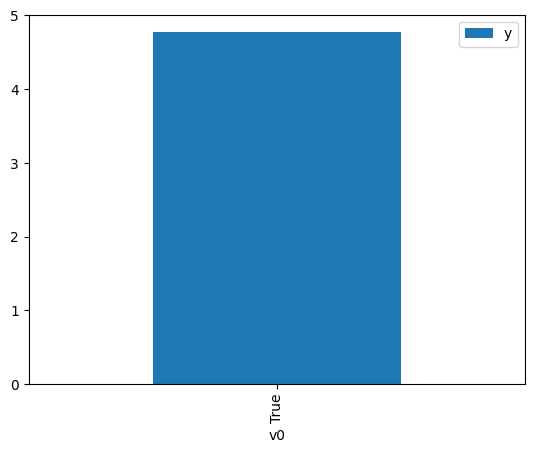

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.504645,False,-1.690800,0.881423,1.134529
1,-1.271635,False,-0.719883,0.844585,1.184014
2,-1.536436,False,-1.601381,0.885817,1.128901
3,-0.521900,False,0.575721,0.664831,1.504141
4,-0.473614,False,-1.010226,0.650216,1.537949
...,...,...,...,...,...
995,-1.851640,False,-1.504164,0.922186,1.084380
996,-1.108646,False,0.707090,0.813611,1.229089
997,-1.870935,False,-2.870493,0.924027,1.082219
998,-1.140591,False,0.611924,0.820036,1.219459


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.292275,True,4.049878,0.407038,2.456772
1,-1.833597,True,4.706013,0.079572,12.567210
2,-2.424888,True,4.041703,0.037578,26.611164
3,-1.285458,True,3.614333,0.152992,6.536308
4,0.053056,True,6.841924,0.521985,1.915765
...,...,...,...,...,...
995,-1.326290,True,1.728799,0.146013,6.848683
996,-1.630039,True,2.912754,0.102060,9.798120
997,-0.887897,True,4.014498,0.235610,4.244296
998,-0.546227,True,3.670496,0.327921,3.049514


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.895
Model:                            OLS   Adj. R-squared (uncentered):              0.894
Method:                 Least Squares   F-statistic:                              4238.
Date:                Mon, 11 Aug 2025   Prob (F-statistic):                        0.00
Time:                        11:05:29   Log-Likelihood:                         -1420.5
No. Observations:                1000   AIC:                                      2845.
Df Residuals:                     998   BIC:                                      2855.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5590      0.026     21.719      0.000       0.508       0.609
x2             5.0079      0.056     90.015      0.000       4.899       5.117
==============================================================================
Omnibus:                        5.525   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                5.699
Skew:                           0.131   Prob(JB):                       0.0579
Kurtosis:                       3.261   Cond. No.                         2.16
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""